# $floZ$: Bayesian evidence estimation from posterior samples with normalizing flows

## Notebook to estimate the evidence from posterior samples and the corresponding un-normalized posterior values.

## Note: 
    1) If you wish to reproduce floZ paper results, remember to run floZ_SampleGeneration_Shared.ipynb first!
    2) If, instead, you're using your custom posterior samples, REMEMBER to save the 2D array [log_likelihood, log_prior, samples] of shape (num_samples x 2+num_dimensions) in ./custom/loglikelihood_logprior_samples.txt.
    3) floZ uses the natural logarithm (base e), instead of the common log (base 10).

### If you have used this code for your research, please cite https://arxiv.org/abs/2404.12294

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import corner
plt.rcParams.update({'font.size': 20})
plt.rc('font',**{'family':'serif'})
plt.rc('text', usetex=True)
import matplotlib.colors as mcolors

from floZ_LossCycle import Trainer
from floZ_LossCycle.train import _pre_whitening
from floZ_LossCycle.utils_Zestimation import *

## Custom or paper posterior distribution?

In [2]:
# If you are interested in using your custom likelihood, set likelihood_label = 'custom'
# Otherwise un-comment the required likelihood label and ndims (dimension of samples) and ninput (number of samples)


## Custom samples
# likelihood_label = 'custom'

## Single Gaussian
N = 1; likelihood_label = 'Likelihood-'+str(N)+'Gaussian'; ndims = 2; ninput = 10000

## Gaussian Mixture
# N = 5; likelihood_label = 'Likelihood-'+str(N)+'Gaussian'; ndims = 2; ninput = 10000

## Rosenbrock
# likelihood_label = 'Likelihood-Rosenbrock'; ndims = 2; ninput = 10000

## Exponential
# likelihood_label = 'Likelihood-Exponential'; ndims = 2; ninput = 10000

## Symmetrize probability density about sharp boundaries?

In [3]:
# symmetric flag: if True, symmetrize probability density about potentially sharp distribution at prior boundaries about the boundaries
symmetric = False

## Load samples, log_likelihood, log_prior from saved file.

In [4]:
if likelihood_label == 'custom':
    
    lnZ_GT = np.nan
    floZpath = likelihood_label
    
    if os.path.exists(os.path.join(floZpath, 'loglikelihood_logprior_samples.txt')):
        s = np.loadtxt(os.path.join(floZpath, 'loglikelihood_logprior_samples.txt'))
    else:
        print('''Please save the log likelihood, log prior and samples as a 2D array of shape (num_samples x 2+num_dimensions)
                in the following location: <floZpath>/loglikelihood_logprior_samples.txt''')
    
    # Dimensions and number of samples. 
    ndims               = samples.shape[1]
    ninput              = samples.shape[0]

else:
    
    floZpath = f'./'+likelihood_label+'_{}d_ninput[{}]'.format(ndims, ninput)
    lnZ_GT = np.loadtxt(os.path.join(floZpath, 'lnZ_GT.txt'))
    print('lnZ GT:  {}'.format(lnZ_GT))
    s = np.loadtxt(os.path.join(floZpath, 'loglikelihood_logprior_samples.txt'))

lnZ GT:  -9.826553052179312


## Initialize floZ network parameters

In [5]:
# general flow settings
flow_type           = 'maf' #options: maf, nvp, nsf

# set layers
num_layers          = ndims+1

# Transformations in MAF
hidden_features      = 5                    # 5 transformation
num_blocks           = 2                    # 2 optimal
num_bins             = 25                   # only nsf and maf

# optimizer settings
learning_rate        = 1e-3
weight_decay         = 1e-4

# dataset settings
Total_number_batches = 8
n_train_batches      = int(ninput*.8)//Total_number_batches         # Batch size
Total_number_batches = ninput//n_train_batches
validation_fraction  = 0.2
shuffle_batches      = True
pre_whitening        = True                                 # Pre-whitening step. Set True

# training settings
training_jitter      = 0.0
cycle_epochs         = 100                                  # Epochs for one cycle.
log_interval         = cycle_epochs//4                      # Time period of each loss AND frequency of loss logging.
max_num_epoch        = 5*cycle_epochs                       # Total epochs.
patience             = cycle_epochs*2                       # Number of epoch cycles to wait to check if validation loss decreases
tolerance            = 0.                                   # Switch off tolerance by setting to 0.

## Set variables for samples, log_p (= log_likelihood + log_prior)

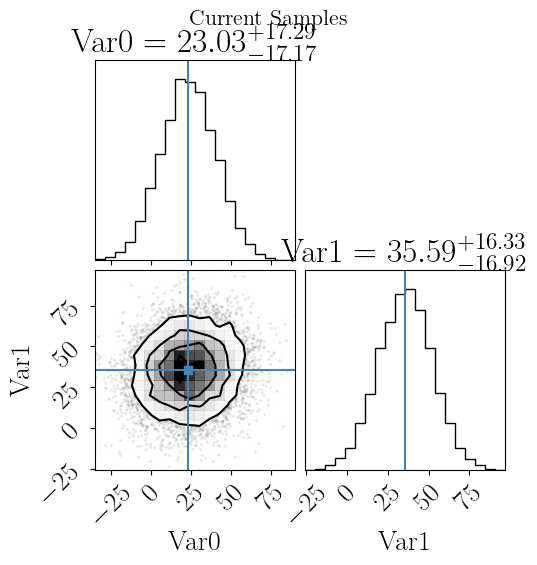

-26.12503399917459 -17.333460370863442


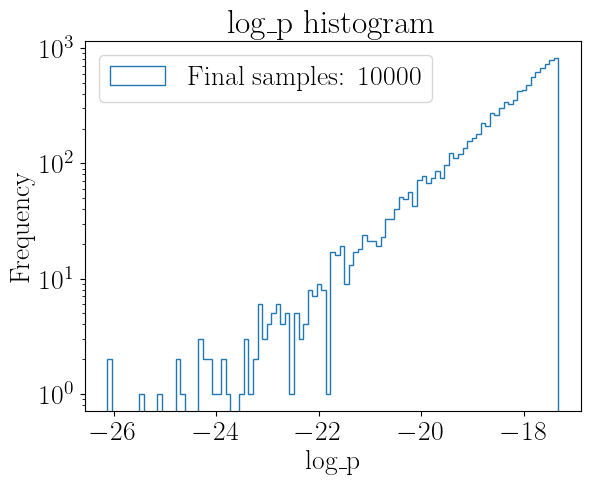

In [6]:
log_likelihood = s[:,0]
log_prior = s[:,1]
log_p = log_likelihood + log_prior
samples = s[:,2:]

log_prior = log_prior[log_p!=-np.inf]
samples = samples[log_p!=-np.inf]
log_likelihood = log_likelihood[log_p!=-np.inf]
log_p = log_p[log_p!=-np.inf]
meanmean = np.mean(samples, axis = 0)

if ndims < 10:
    # Plot the corner plot of the samples.
    figure = corner.corner(np.transpose(samples.T), labels=["Var"+str(index) for index in range(len(samples.T))], show_titles=True, truths=meanmean)
    figure.suptitle("Current Samples", y=1.02, fontsize=16)
    plt.show()

plt.figure()
plt.title('log_p histogram')
print(np.min(log_p), np.max(log_p))
bins = np.linspace(np.min(log_p), np.max(log_p), 100)
plt.hist(log_p, bins = bins, histtype = 'step', label = 'Final samples: {}'.format(len(log_p)))
plt.yscale('log')
plt.xlabel('log_p')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Subtract mean of samples to bring to same origin.

In [7]:
samples -= np.mean(samples, axis = 0)

## Visualizing the pre-processing step: the whitened distribution

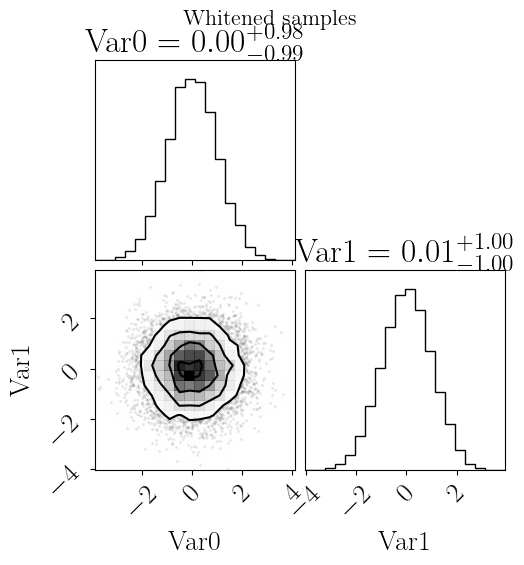

In [8]:
if ndims < 10:
    whitened_samples,log_j_white = _pre_whitening(samples)
    # whitened_samples -= np.mean(whitened_samples, axis = 0)
    whitened_log_p = log_p + log_j_white
    # # print(log_j_white, log_p)
    # plt.hist(log_p)
    # plt.axvline(log_j_white, color = 'k', ls = '--')
    # plt.show()

    figure = corner.corner(whitened_samples, labels=["Var"+str(index) for index in range(len(whitened_samples.T))], show_titles=True)
                           # , color=color_values_rgb, plot_density=False, plot_contours=False, fill_contours=False)
    figure.suptitle("Whitened samples", y=1.02, fontsize=16)
    plt.show()

## Define sub-directory to save the floZ evidence results

In [9]:
floZpath_Evidence = os.path.join(floZpath, 'nbatch[{}]_Linterval[{}]'.format(n_train_batches, log_interval))
print(floZpath_Evidence)

if os.path.exists(floZpath_Evidence) == False:
    os.makedirs(floZpath_Evidence)

./Likelihood-1Gaussian_2d_ninput[10000]/nbatch[1000]_Linterval[25]


## Symmetrize if symmetric flag == True and in the presence of high density near prior boundaries

In [10]:
if(symmetric):#
    if os.path.exists(os.path.join(floZpath_Evidence, 'Symmetrized_logp_samples.txt')):
        s = np.loadtxt(os.path.join(floZpath_Evidence, 'Symmetrized_logp_samples.txt'))
        log_p = s[:,0]
        samples = s[:,1:]
    else:
        samples, log_p = symmetrize(samples, log_p)#, upper = True, ax=[0,1])
        meanmean = np.mean(samples, axis = 0)
        np.savetxt(os.path.join(floZpath_Evidence, 'Symmetrized_logp_samples.txt'), np.hstack((log_p[:, np.newaxis], samples)))
        
        if ndims < 10:
            # Plot the corner plot
            figure = corner.corner(np.transpose(samples.T), labels=["Var"+str(index) for index in range(len(samples.T))], show_titles=True, truths=meanmean)
            figure.suptitle("Current Samples", y=1.02, fontsize=16)
            plt.show()
        
    plt.figure()
    plt.title('log_p histogram')
    print(np.min(log_p), np.max(log_p))
    bins = np.linspace(np.min(log_p), np.max(log_p), 100)
    plt.hist(log_p, bins = bins, histtype = 'step', label = 'Final samples: {}'.format(len(log_p)))
    plt.yscale('log')
    plt.xlabel('log_p')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## Initialize floZ Network

In [11]:
# zflows evidence
t       = Trainer(
                samples, log_p,
                outdir                 = floZpath_Evidence,
                seed                   = None,
                  
                # Cpu: 'cpu' & GPU: 'cuda'. Setting to 'cuda' will check if cuda available; if not, it will set to 'cpu' automatically.
                device                 = 'cuda',
                
                # normalizing flow settings
                base_dist              = 'normal',
                transform              = 'maf',
                transform_dict         = {'num_layers':       num_layers,
                                        'num_blocks':       num_blocks,
                                        'hidden_features':  hidden_features,
                                        'num_bins':         num_bins
                                        },
                
                # optmizer settings
                learning_rate          = learning_rate,
                weight_decay           = weight_decay,
                
                # data settings
                n_train_batches        = n_train_batches,
                validation_fraction    = validation_fraction,
                shuffle_batches        = shuffle_batches,
                pre_whitening          = pre_whitening,
                lnZ_GT                 = lnZ_GT,
                )

[zflows] [09-10-2024 13:17] GT of lnZ: -9.826553052179312
[zflows] [09-10-2024 13:17] Available GPUs: 1
[zflows] [09-10-2024 13:17] Output directory: /u/r/rsriniva/flows/Public_code/Likelihood-1Gaussian_2d_ninput[10000]/nbatch[1000]_Linterval[25]
[zflows] [09-10-2024 13:17] Dimensions of parameter space: 2
[zflows] [09-10-2024 13:17] Number of input samples: 10000
[zflows] [09-10-2024 13:17] Number of network parameters: 2175
[zflows] [09-10-2024 13:17] Working device: cuda
[zflows] [09-10-2024 13:17] Whitening samples with covariance error of 1.47e-16
[zflows] [09-10-2024 13:17] Splitting input samples in training set (8000) and validation set (2000)


Training first batch:  torch.Size([1000])
Training last batch:  torch.Size([1000])
Validation first batch:  torch.Size([1000])
Validation last batch:  torch.Size([1000])


## Training

[zflows] [09-10-2024 13:17] Output directory: /u/r/rsriniva/flows/Public_code/Likelihood-1Gaussian_2d_ninput[10000]/nbatch[1000]_Linterval[25]
[zflows] [09-10-2024 13:17] Starting training of neural network ...
[zflows] [09-10-2024 13:17] Total # batches: 8
[zflows] [09-10-2024 13:17] Training starts
[zflows] [09-10-2024 13:17] Saving current best state dictionary
[zflows] [09-10-2024 13:17] Creating pairs
[zflows] [09-10-2024 13:17] Pairs created
[zflows] [09-10-2024 13:17] Train pair shape (499500, 2)
[zflows] [09-10-2024 13:17] Validation pair shape (499500, 2)
[zflows] [09-10-2024 13:17] GPU memory: Allocated 0.02 GB, Reserved 0.07 GB
[zflows] [09-10-2024 13:17] > Epoch 1 - train loss 3.11989 - valid loss 3.05202 - best valid loss 3.05202
/u/r/rsriniva/flows/Public_code/floZ_LossCycle/train.py:499: RuntimeWarning: divide by zero encountered in log
  if self.evidence_error/self.evidence_mean < np.log(tolerance):
[zflows] [09-10-2024 13:17] > Epoch 25 - train loss 2.84079 - valid los

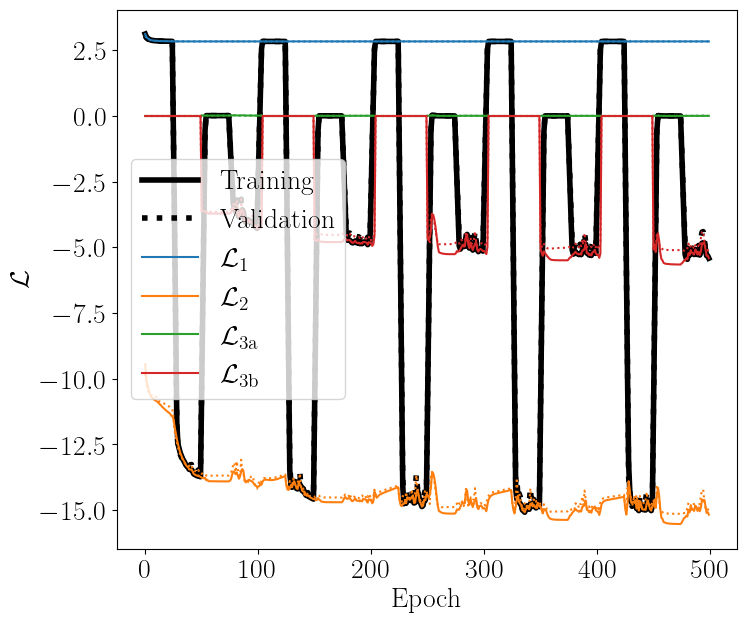

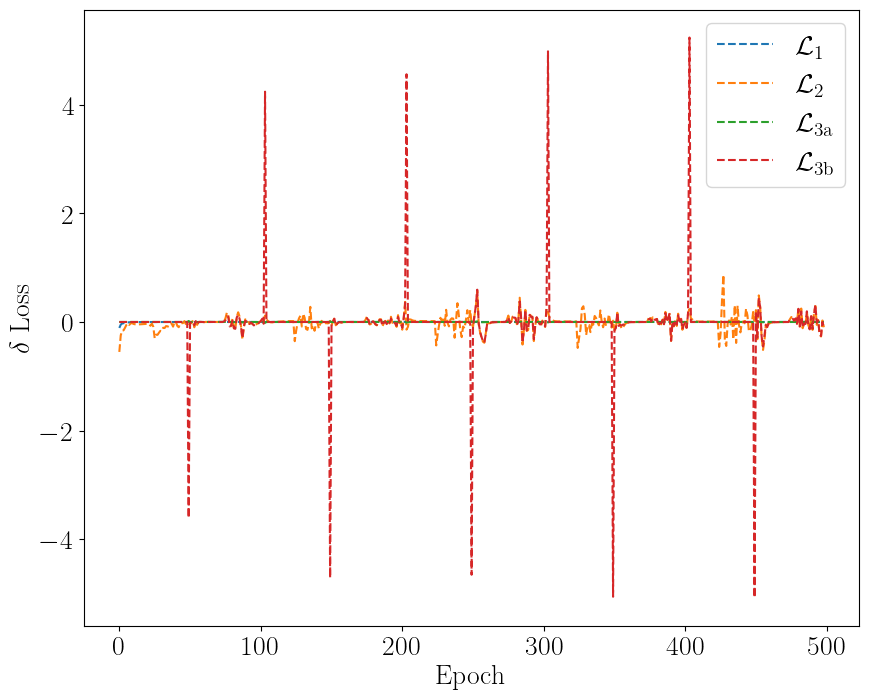

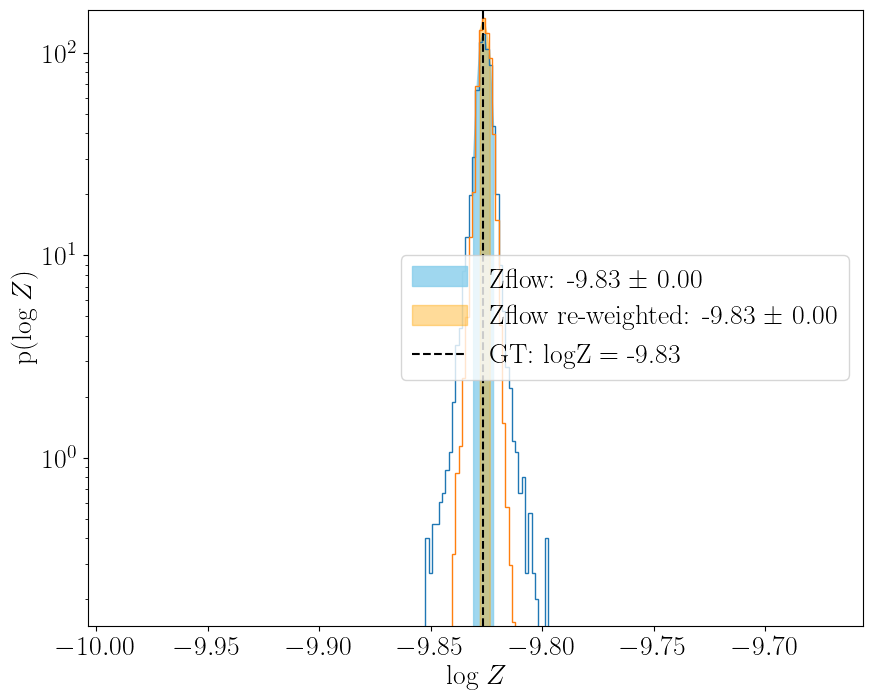

In [12]:
t.train(max_num_epoch   = max_num_epoch,
        patience        = patience,
        tolerance       = tolerance,
        log_interval    = log_interval)

## Reload the loss evolution

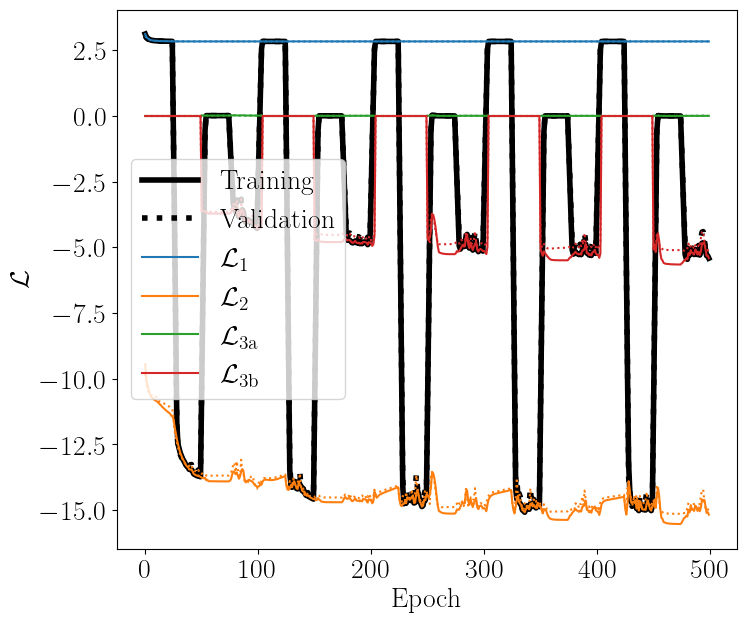

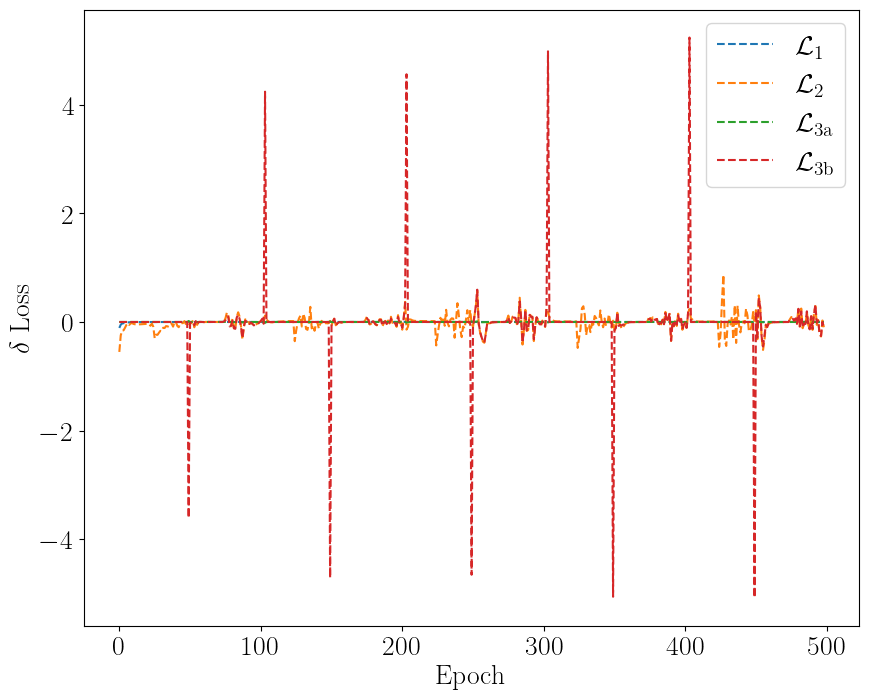

In [13]:
[train_loss_history, valid_loss_history, train_loss_1_history,
     validation_loss_1_history, train_loss_2_history, validation_loss_2_history,  train_loss_3a_history,
        validation_loss_3a_history , train_loss_3b_history, validation_loss_3b_history] = np.loadtxt(os.path.join(floZpath_Evidence, 'losses.txt'))

t._plot_LossEvolution(saveflag = False)
plt.show()
# # plt.savefig('5Gaussian_2D_Loss_history.png', dpi=150, bbox_inches='tight')

## If symmetric == True, load pre-saved symmetrized samples.

In [14]:
if(symmetric and likelihood_label == 'Likelihood-Exponential' and os.path.exists(os.path.join(floZpath_Evidence, 'Symmetrized_logp_samples.txt'))):
    s = np.loadtxt(os.path.join(floZpath_Evidence, 'Symmetrized_logp_samples.txt'))
    log_p = s[:,0]
    samples = s[:,1:]

## Load trained floZ in evaluation mode

In [15]:
print(floZpath_Evidence)
# zflows evidence
t1       = Trainer(samples, log_p,
                    outdir                 = floZpath_Evidence,
                    seed                   = None,
                    device                 = 'cuda',
                    # normalizing flow settings
                    base_dist              = 'normal',
                    transform              = 'maf',
                    transform_dict         = {'num_layers':     num_layers,
                                            'num_blocks':       num_blocks,
                                            'hidden_features':  hidden_features,
                                            'num_bins':         num_bins
                                            },
                    # optmizer settings
                    learning_rate          = learning_rate,
                    weight_decay           = weight_decay,
                    # data settings
                    n_train_batches        = n_train_batches,
                    validation_fraction    = validation_fraction,
                    shuffle_batches        = shuffle_batches,
                    pre_whitening          = pre_whitening,
                    lnZ_GT                 = lnZ_GT,
                    )

import torch
t1.flow.load_state_dict(torch.load(os.path.join(floZpath_Evidence, 'flow_state.pt')))
t1.flow.eval()

[zflows] [09-10-2024 13:23] GT of lnZ: -9.826553052179312
[zflows] [09-10-2024 13:23] Available GPUs: 1
[zflows] [09-10-2024 13:23] Output directory: /u/r/rsriniva/flows/Public_code/Likelihood-1Gaussian_2d_ninput[10000]/nbatch[1000]_Linterval[25]
[zflows] [09-10-2024 13:23] Dimensions of parameter space: 2
[zflows] [09-10-2024 13:23] Number of input samples: 10000
[zflows] [09-10-2024 13:23] Number of network parameters: 2175
[zflows] [09-10-2024 13:23] Working device: cuda
[zflows] [09-10-2024 13:23] Whitening samples with covariance error of 1.47e-16
[zflows] [09-10-2024 13:23] Splitting input samples in training set (8000) and validation set (2000)


./Likelihood-1Gaussian_2d_ninput[10000]/nbatch[1000]_Linterval[25]
Training first batch:  torch.Size([1000])
Training last batch:  torch.Size([1000])
Validation first batch:  torch.Size([1000])
Validation last batch:  torch.Size([1000])


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): ReversePermutation()
      (1): MaskedPiecewiseQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=5, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=5, out_features=5, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=5, out_features=98, bias=True)
        )
      )
      (2): ReversePermutation()
      (3): MaskedPiecewiseQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=5, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): Mod

## Z prediction

Evidence =  5.3998566816936114e-05
log_e (Evidence) =  -9.826553052179312
Number of samples in set B: 6299 out of total 10000


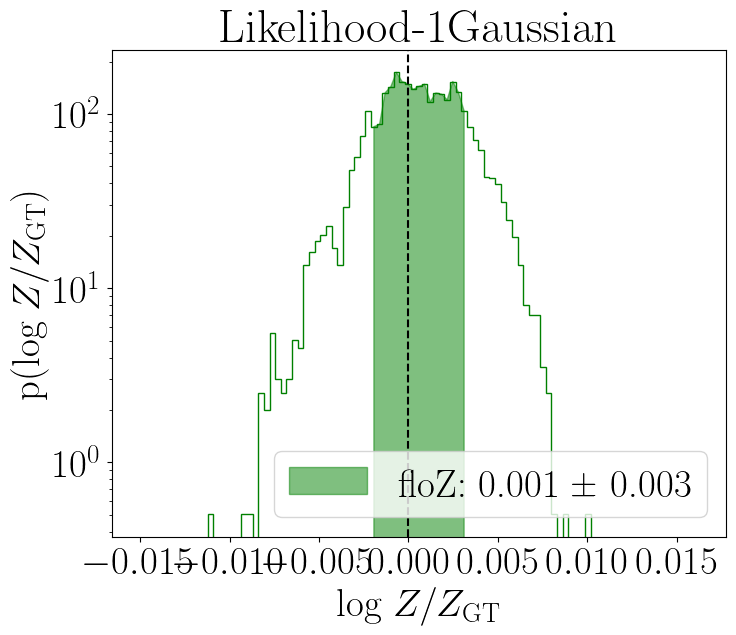

In [16]:
whitened_samples,_ = _pre_whitening(samples)

# Compute the latent samples for the post-processing step of selecting B ellipsoid
with torch.no_grad():
    # Sampling from real space -> latent space
    if ninput>2e5:
        num_batches = 10
        batch_len = len(whitened_samples)//num_batches
        batch_idx = np.arange(0, len(whitened_samples), batch_len)
        # Ensure the last index spans the length
        if batch_idx[-1] != len(whitened_samples):
            batch_idx = np.append(batch_idx, len(whitened_samples))
    else:
        batch_idx = np.arange(0,len(whitened_samples))
    # print('posterior samples device: ', whitened_samples.device)
    
    latent_samples = np.zeros_like(whitened_samples)
    for i in range(len(batch_idx)-1):
        ws = torch.tensor(whitened_samples[batch_idx[i] : batch_idx[i+1]], dtype=torch.float32).to(torch.device('cuda'))
        ls, _ = t1.flow._transform(ws)
        latent_samples[batch_idx[i] : batch_idx[i+1]] = ls.detach().cpu().numpy()

# Calculation of Evidence
print('Evidence = ', np.exp(lnZ_GT))
print('log_e (Evidence) = ', lnZ_GT)

rescale_linear = -lnZ_GT
# Load flow logz
import torch

logz = t1._get_logz_from_samples().cpu()# - rescale
lnZ = np.array(logz.detach().numpy())
lnP = np.array(log_p)

fig = plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 28})

# Histogram the restricted set
delta_squared = float(ndims)
restricted_set = np.where(np.sum( (latent_samples)**2, axis = 1) < delta_squared)[0]
print(f"Number of samples in set B: {len(restricted_set)} out of total {len(samples)}")
lnZ = lnZ[restricted_set]
lnP = lnP[restricted_set]

if likelihood_label == 'Likelihood-Rosenbrock' and ndims > 2 and np.isnan(lnZ_GT):
    rescale_linear = -np.mean(lnZ)

lnZ_rescaled = lnZ + rescale_linear
lnZ_GT_rescaled = lnZ_GT+rescale_linear

def weighted_mean_and_std(values, weights):
    weighted_mean = np.average(values, weights=weights)
    variance = np.average((values - weighted_mean)**2, weights=weights)
    weighted_std = np.sqrt(variance)
    return weighted_mean, weighted_std
logz_mean_reweight, logz_std_reweight = weighted_mean_and_std(values=lnZ_rescaled, weights=np.ones_like(lnP))

lims = [logz_mean_reweight-6*logz_std_reweight, logz_mean_reweight+6*logz_std_reweight]

bins = np.linspace(np.min(lims), np.max(lims), 100)
bins_mean = (bins[1:] + bins[:-1])*.5

pdf_reweight, _, _ = plt.hist(lnZ_rescaled, density=True, bins=bins, histtype = 'step', weights = np.ones_like(lnP), color = 'green')# label = 'Zflow Ellipse reweighted')

plt.fill_between(bins_mean, 0, pdf_reweight, where=((bins_mean >= logz_mean_reweight - logz_std_reweight) & (bins_mean <= logz_mean_reweight + logz_std_reweight)), color='green', alpha=0.5, label=r'floZ'+': '+'{:.3f} ± {:.3f}'.format(logz_mean_reweight, logz_std_reweight))#, label=r'floZ $\in \mathcal{B}$'+': '+'{:.3f} ± {:.3f}'.format(logz_mean_reweight, logz_std_reweight))

plt.axvline(lnZ_GT_rescaled, c='k', ls = '--')#, label= 'GT: {:.2f}'.format(lnZ_GT))
plt.xlabel('log $Z/Z_\mathrm{GT}$')
plt.ylabel('p(log $Z/Z_{\mathrm{GT}}$)')
plt.yscale('log')

plt.title(likelihood_label)

# Add a legend with handle and label
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend(handles=handles[:], labels=labels[:])#, loc = 'lower left')
plt.tight_layout()
plt.savefig(os.path.join(floZpath_Evidence, 'logZ_withGT_RestrictedSampling.png'), bbox_inches='tight')#, bbox_inches='tight')
plt.rcParams.update({'font.size': 20})

# Testing the credibility of the predictions
## Q) Has the flow completed its training (check loss evolution)?
## $\,\,\,\,\,\,\,$- No: increase max_num_epoch.
## $\,\,\,\,\,\,\,$- Yes: Q) Is it able to reproduce the posterior distribution (check below diagnostics)?
## $\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,$- No: increase flow model complexity.
## $\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,$- Yes: end.

## Functions to compare two distributions by computing KL divergence.

In [17]:
import numpy as np
from scipy.special import rel_entr

def kl_divergence(ground_truth, predicted):
    p = np.asarray(ground_truth, dtype=np.float32)
    q = np.asarray(predicted, dtype=np.float32)
    return np.sum(rel_entr(p, q))

import numpy as np
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

def estimate_distribution(samples, bins):
    hist, bin_edges = np.histogram(samples, bins=bins, density=True)
    # Normalize the histogram
    hist = hist / np.sum(hist)
    return hist, bin_edges

def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

def js_divergence(p, q):
    return jensenshannon(p, q) ** 2

def wasserstein_dist(p, q, bin_edges):
    # Use the midpoints of the bins for the Wasserstein distance
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return wasserstein_distance(bin_centers, bin_centers, p, q)

def compare_distributions(samples_gt, samples_pred, bins=10):
    # Estimate distributions from samples
    p, bin_edges = estimate_distribution(samples_gt, bins)
    q, _ = estimate_distribution(samples_pred, bins)
    
    kl_div = kl_divergence(p, q)
    js_div = js_divergence(p, q)
    wasserstein_dist_val = wasserstein_dist(p, q, bin_edges)
    
    return {
        'KL Divergence': kl_div,
        'JS Divergence': js_div,
        'Wasserstein Distance': wasserstein_dist_val
    }

## Visualize the real <--> latent space mapping (diagnostic to determine flow's effectiveness)

/u/r/rsriniva/miniconda3/envs/py3p9/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(


Latent Space Comparison: {'KL Divergence': inf, 'JS Divergence': 0.005718860731604102, 'Wasserstein Distance': 0.07391279786605823}
0 (10000, 2)


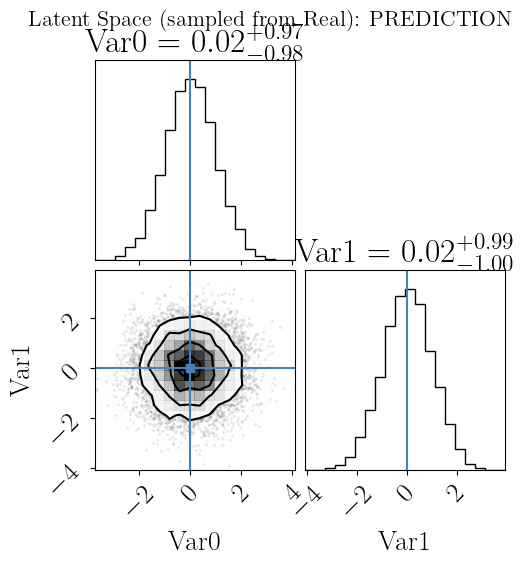

(10000, 2) (10000, 2) (10000,)
Density of Latent samples
Latent Space
Real Space


<Figure size 600x2000 with 0 Axes>

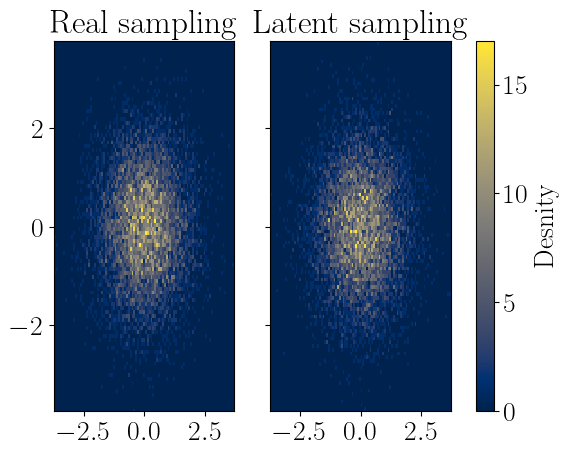

<Figure size 600x2000 with 0 Axes>

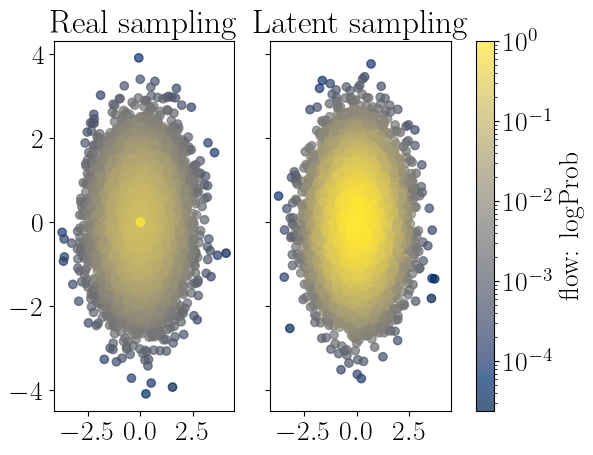

<Figure size 600x2000 with 0 Axes>

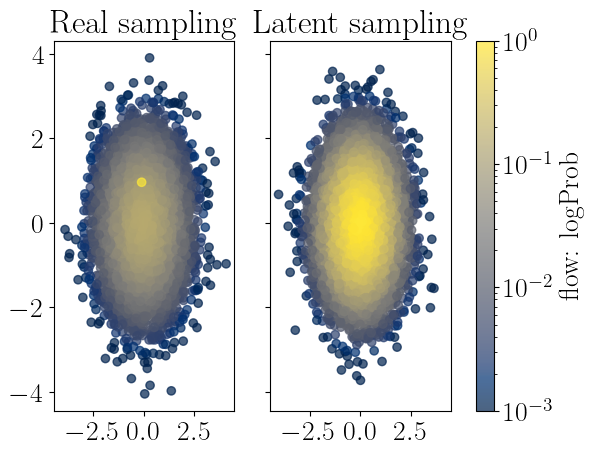

In [18]:
# samples_flow = t1.flow._transform(samples)
import matplotlib.colors as mcolors

whitened_samples,_ = _pre_whitening(samples)

with torch.no_grad():
    # Sampling from real space -> latent space
    if ninput>2e5:
        num_batches = 10
        batch_len = len(whitened_samples)//num_batches
        batch_idx = np.arange(0, len(whitened_samples), batch_len)
        # Ensure the last index spans the length
        if batch_idx[-1] != len(whitened_samples):
            batch_idx = np.append(batch_idx, len(whitened_samples))
    else:
        batch_idx = np.arange(0,len(whitened_samples))
    # print('posterior samples device: ', whitened_samples.device)
    
    flow_logprob = np.zeros(len(whitened_samples))
    latent_samples = np.zeros_like(whitened_samples)
    # logabsdet =  np.zeros(len(whitened_samples))
    for i in range(len(batch_idx)-1):
        ws = torch.tensor(whitened_samples[batch_idx[i] : batch_idx[i+1]], dtype=torch.float32).to(torch.device('cuda'))
        ls, _ = t1.flow._transform(ws)
        latent_samples[batch_idx[i] : batch_idx[i+1]] = ls.detach().cpu().numpy()
        flow_logprob[batch_idx[i] : batch_idx[i+1]] = t1.flow.log_prob(ws).detach().cpu().numpy()
        # logabsdet[batch_idx[i] : batch_idx[i+1]] = logdet.detach().cpu().numpy()
    
    # Sampling from latent space -> real space: 
    # Max 1e5 samples!!
    latent_samples_uniform = torch.tensor(np.random.multivariate_normal(np.zeros(ndims), np.eye(ndims), min(int(1e5), len(whitened_samples))), dtype=torch.float32).to(torch.device('cuda'))
    whitened_samples_uniform, logabsdet_uniform = t1.flow._transform.inverse(latent_samples_uniform)
    flow_logprob_uniform = t1.flow.log_prob(whitened_samples_uniform).detach().cpu().numpy()
    whitened_samples_uniform = whitened_samples_uniform.detach().cpu().numpy()
    latent_samples_uniform = latent_samples_uniform.detach().cpu().numpy()
    logabsdet_uniform = logabsdet_uniform.detach().cpu().numpy()

    print("Latent Space Comparison:", compare_distributions(latent_samples_uniform, latent_samples, bins=300))
    # print("Real Space Comparison:", compare_distributions(whitened_samples, whitened_samples_uniform, bins=300))
    plt.close()
    # whitened_samples_uniform[np.isnan(whitened_samples_uniform)] = 0.
    if ndims < 100:
        pltdims = min(samples.shape[1], 10)

        for i in np.arange(0, samples.shape[1], pltdims):
            print(i, latent_samples[:,i:i+pltdims].shape)
            figure = corner.corner(latent_samples[:,i:min(i+pltdims, ndims)], labels=["Var"+str(i+index) for index in range(min(pltdims, ndims-i))], show_titles=True, truths=np.zeros(min(pltdims, ndims-i)))
            figure.suptitle("Latent Space (sampled from Real): PREDICTION", y=1.02, fontsize=16)
            plt.show()
    
        # figure = corner.corner(latent_samples_uniform, truths = np.zeros(samples.shape[1]), labels=["Var"+str(index) for index in range(len(samples.T))])
        # figure.suptitle("Latent Space (sampled from Latent): TARGET", y=1.02, fontsize=16)
        
        
        # figure = corner.corner(whitened_samples_uniform, labels=["Var"+str(index) for index in range(len(samples.T))])
        # figure.suptitle("Real Space (sampled from Latent): PREDICTION", y=1.02, fontsize=16)
        # figure = corner.corner(whitened_samples, labels=["Var"+str(index) for index in range(len(samples.T))])
        # figure.suptitle("Real Space (sampled from Real): TARGET", y=1.02, fontsize=16)
    
    # print("Control Comparison:", compare_distributions(latent_samples_uniform, latent_samples_uniform, bins=30))
    
    print(latent_samples.shape, whitened_samples.shape, flow_logprob.shape)
    if(ndims==2):
        
        print('Density of Latent samples')
        plt.figure(figsize = (6,20))
        fig, axes = plt.subplots(1, 2, sharex = True, sharey = True)
        h1 = axes[0].hist2d(latent_samples[:,0], latent_samples[:,1], bins=100, cmap='cividis')
        h2 = axes[1].hist2d(latent_samples_uniform[:,0], latent_samples_uniform[:,1], bins=100, cmap='cividis')
        cbar = fig.colorbar(h1[3], ax=axes, orientation='vertical')
        cbar.set_label('Desnity')
        axes[0].set_title('Real sampling')
        axes[1].set_title('Latent sampling')
        
        
        print('Latent Space')
        plt.figure(figsize = (6,20))
        fig, axes = plt.subplots(1, 2, sharex = True, sharey = True)
        sc1 = axes[0].scatter(latent_samples[:,0], latent_samples[:,1], c=np.exp(flow_logprob), cmap='cividis', alpha = .7, norm=mcolors.LogNorm())
        # sc2 = axes[1].scatter(latent_samples_uniform[:,0], latent_samples_uniform[:,1], c=multivariate_normal(mean=[0,0], cov = [[1,0],[0,1]]).pdf(latent_samples_uniform), cmap='cividis', alpha = .7, norm=mcolors.LogNorm(vmin = 1e-3))
        sc2 = axes[1].scatter(latent_samples_uniform[:,0], latent_samples_uniform[:,1], c=np.exp(flow_logprob_uniform), cmap='cividis', alpha = .7, norm=mcolors.LogNorm())
        cbar = fig.colorbar(sc1, ax=axes, orientation='vertical')
        cbar.set_label('flow: logProb')
        axes[0].set_title('Real sampling')
        axes[1].set_title('Latent sampling')
        plt.savefig(os.path.join(floZpath_Evidence, 'LatentSamples.png'), bbox_inches='tight')#, bbox_inches='tight')

        
        print('Real Space')
        plt.figure(figsize = (6,20))
        fig, axes = plt.subplots(1, 2, sharex = True, sharey = True)
        sc1 = axes[0].scatter(whitened_samples[:,0], whitened_samples[:,1], c=np.exp(flow_logprob), cmap='cividis', alpha = .7, norm=mcolors.LogNorm(vmin = 1e-3))
        sc2 = axes[1].scatter(whitened_samples_uniform[:,0], whitened_samples_uniform[:,1], c=np.exp(flow_logprob_uniform), cmap='cividis', alpha = .7, norm=mcolors.LogNorm(vmin = 1e-3))
        cbar = fig.colorbar(sc1, ax=axes, orientation='vertical')
        cbar.set_label('flow: logProb')
        axes[0].set_title('Real sampling')
        axes[1].set_title('Latent sampling')
        plt.savefig(os.path.join(floZpath_Evidence, 'RealSamples.png'), bbox_inches='tight')#, bbox_inches='tight')
        plt.show()

        # plt.scatter(samples[:,0], samples[:,1], c=flow_logprob, cmap='viridis', alpha = .1)
        # plt.colorbar(label = 'flow log prob')
        # plt.show()

## $\mu$ - $\sigma$ plot: diagnosing successful training of flow.

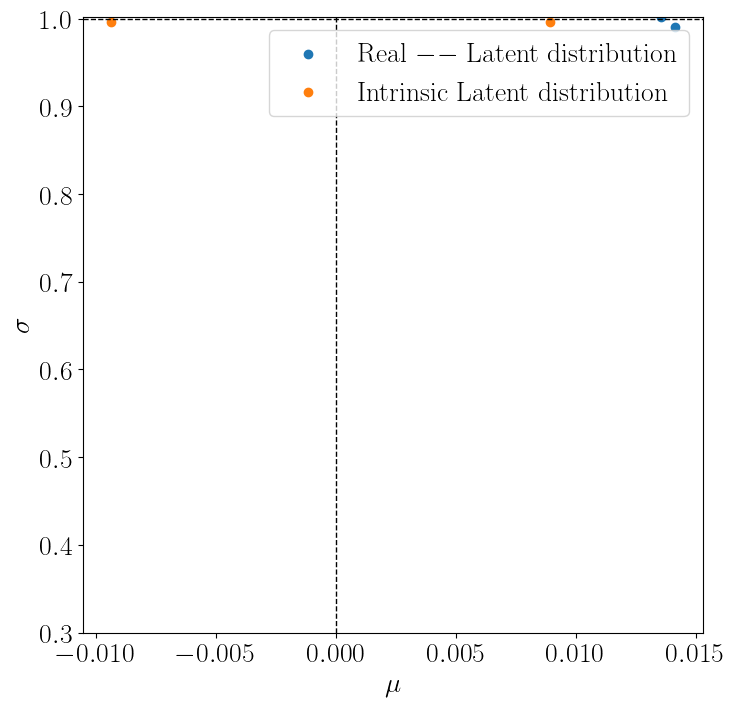

In [19]:
def weighted_mean_and_std(values, weights):
    weighted_mean = np.average(values, weights=weights)
    variance = np.average((values - weighted_mean)**2, weights=weights)
    weighted_std = np.sqrt(variance)
    return weighted_mean, weighted_std

plt.figure(figsize=(8,8))

musigma = []
for i in range(samples.shape[1]):
    musigma += [weighted_mean_and_std(values=latent_samples[:,i], weights=np.ones(len(samples)))]
musigma = np.array(musigma)
plt.scatter(musigma[:,0], musigma[:,1], label = 'Real $--$ Latent distribution')

musigma = []
for i in range(samples.shape[1]):
    musigma += [weighted_mean_and_std(values=latent_samples_uniform[:,i], weights=np.ones(len(latent_samples_uniform)))]
musigma = np.array(musigma)
plt.scatter(musigma[:,0], musigma[:,1], label = 'Intrinsic Latent distribution')

plt.axhline(1. , c='k', ls = '--', lw = 1)
plt.axvline(0. , c='k', ls = '--', lw = 1)
plt.ylim(0.3)
plt.legend()
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.show()

## Optionally, kill the kernerl and free memory

In [ ]:
os._exit(00)